> Created on Sat Nov 12 16:10:54 2022  @author: Richie Bao-caDesign设计(cadesign.cn)

## 2.7.3 空间自相关分析

### 2.7.2.1 

#### 1）白噪

In [1]:
from database import postSQL2gpd,gpd2postSQL
from util_misc import AttrDict
__C=AttrDict() 
args=__C

__C.db=AttrDict() 
__C.db.UN='postgres'
__C.db.PW='123456'
__C.db.DB='AoT_20220831'
__C.db.GC='geometry' 
__C.db.db_info=dict(geom_col=args.db.GC,myusername=args.db.UN,mypassword=args.db.PW,mydatabase=args.db.DB)

__C.gi=AttrDict()
__C.gi.Chicago_epsg=32616
__C.gi.epsg_wgs84=4326

In [2]:
aot_concentration_gdf=postSQL2gpd(table_name="concentration_2019",**args.db.db_info)
aot_concentration_CO_gdf=aot_concentration_gdf[aot_concentration_gdf['sensor']=="co"]

C:\Users\richi\anaconda3\envs\usda\lib\site-packages\pandas\io\sql.py:580: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  pandas_sql.meta.reflect(bind=pandas_sql.connectable, only=[sql])


__________________________________________________
The data has been read from PostgreSQL database. The table name is concentration_2019.


In [3]:
print(f"sample size: {len(aot_concentration_CO_gdf)}")
aot_concentration_CO_gdf[:3]

sample size: 72853


,timestamp,node_id,subsystem,sensor,parameter,value_hrf_sum,value_hrf_count,value_hrf_average,value_hrf_min,value_hrf_max,project_id,vsn,address,lat,lon,description,start_timestamp,end_timestamp,geometry,ts
9,2019/01/01 00:30:00,001e06114fd4,chemsense,co,concentration,14.802,98,0.151,0.003,0.467,AoT_Chicago,073,Martin Luther King Dr & Garfield Blvd Chicago IL,41.794477,-87.615957,AoT Chicago (S) [C],2018/03/08 00:00:00,None,POINT (448823.977 4627140.987),2019-01-01 00:30:00
17,2019/01/01 00:30:00,001e0610f05c,chemsense,co,concentration,4.088,35,0.117,0.001,0.408,AoT_Chicago,08C,Western Ave & Fullerton Ave Chicago IL,41.924903,-87.687703,AoT Chicago (S) [C],2018/02/07 00:00:00,None,POINT (442979.008 4641666.996),2019-01-01 00:30:00
26,2019/01/01 00:30:00,001e0610eef2,chemsense,co,concentration,36.666,124,0.296,0.009,0.786,AoT_Chicago,088,Clark St & Wilson Ave Chicago IL,41.965256,-87.666720,AoT Chicago (S) [C],2018/02/14 00:00:00,None,POINT (444753.675 4646133.593),2019-01-01 00:30:00


In [4]:
aot_CO_gdf=aot_concentration_CO_gdf[['ts','node_id','value_hrf_average','geometry']].sort_values(by=['ts'])
aot_CO_gdf[:3]

,ts,node_id,value_hrf_average,geometry
9,2019-01-01 00:30:00,001e06114fd4,0.151,POINT (448823.977 4627140.987)
124,2019-01-01 00:30:00,001e0610ba46,0.206,POINT (447918.217 4636463.149)
119,2019-01-01 00:30:00,001e0610e537,0.108,POINT (444814.510 4645729.616)


In [23]:
def df_group_resample(df,val_column,time_column,rules,methods=["mean","min","max"],group_column=None,geometry_column=None):
    from pandas.api.types import is_datetime64_any_dtype as is_datetime
    import pandas as pd
    import geopandas as gpd
    from tqdm import tqdm
    from shapely import wkt
    
    df_notna=df[df[val_column].notna()]
    if is_datetime(df_notna[time_column]):
        df_notna.rename(columns={time_column:"ts"},inplace=True)
    else:
        df_notn['ts']=pd.to_datetime(df_notna[time_column])
    df_notna.sort_values(by=["ts"],inplace=True)
    df_notna[val_column]=df_notna[val_column].astype("float")
    if geometry_column:
        crs=df_notna.crs
        print(f"CRS={crs}")
    
    if group_column:
        df_group=df_notna.groupby(group_column)    
        nodeID_geometry_mapping={}
        g_v_resample_lst=[]
        for g_n,g_v in tqdm(df_group):
            g_v.set_index('ts',inplace=True)       
            if geometry_column:
                nodeID_geometry_mapping[g_n]=g_v.iloc[[0]].geometry.values[0].wkt
            g_v_resample_r_dict={}
            for r in rules:               
                g_v_resample=g_v[val_column].resample(r)
                g_v_resample_methods_dict={}
                for m in methods:
                    if m=="mean":
                        g_v_resample_mean=g_v_resample.mean()
                        g_v_resample_methods_dict["mean"]=g_v_resample_mean
                    elif m=="min":
                        g_v_resample_min=g_v_resample.min()
                        g_v_resample_methods_dict["min"]=g_v_resample_min=g_v_resample_min
                    elif m=="max":
                        g_v_resample_max=g_v_resample.max()
                        g_v_resample_methods_dict["max"]=g_v_resample_min=g_v_resample_max
                    else:
                        pass
                g_v_resample_r_dict[r]=pd.concat(g_v_resample_methods_dict,axis=1)  
                
            g_v_resample_r_df=pd.concat(g_v_resample_r_dict,axis=1)     
            g_v_resample_r_df.columns=g_v_resample_r_df.columns.map("_".join).str.strip("_")
            g_v_resample_r_df[group_column]=g_n
            g_v_resample_lst.append(g_v_resample_r_df)
            
        g_v_resample_df=pd.concat(g_v_resample_lst)
        if geometry_column:
            g_v_resample_df[geometry_column]=g_v_resample_df[group_column].map(nodeID_geometry_mapping)
            g_v_resample_df[geometry_column]=g_v_resample_df[geometry_column].apply(wkt.loads)
            g_v_resample_df=gpd.GeoDataFrame(g_v_resample_df,geometry=geometry_column,crs=crs)  
            g_v_resample_df.reset_index(inplace=True)
        return g_v_resample_df
    
    else:
        df_notna.set_index('ts',inplace=True) 
        df_notna_resample_r_dict={}
        for r in rules:                  
            df_notna_resample=df_notna[val_column].resample(r)
            df_notna_resample_methods_dict={}
            for m in methods:
                if m=="mean":
                    df_notna_resample_mean=df_notna_resample.mean()
                    df_notna_resample_methods_dict["mean"]=df_notna_resample_mean
                elif m=="min":
                    df_notna_resample_min=df_notna_resample.min()
                    df_notna_resample_methods_dict["min"]=df_notna_resample_min
                elif m=="max":
                    df_notna_resample_max=df_notna_resample.max()
                    df_notna_resample_methods_dict["max"]=df_notna_resample_max
                else:
                        pass        
            df_notna_resample_r_dict[r]=pd.concat(df_notna_resample_methods_dict,axis=1)    
        df_notna_resample_r_df=pd.concat(df_notna_resample_r_dict,axis=1)   
        df_notna_resample_r_df.reset_index(inplace=True)
        return df_notna_resample_r_df
    
df_group_resample_D_gdf=df_group_resample(aot_CO_gdf,"value_hrf_average","ts",["Y"],["mean"],group_column="node_id",geometry_column="geometry")    
df_group_resample_D_gdf

CRS=epsg:32616


100%|██████████| 65/65 [00:00<00:00, 137.79it/s]


,ts,Y_mean,node_id,geometry
0,2019-12-31,2.497887,001e06109401,POINT (449143.139 4615032.869)
1,2019-12-31,0.218547,001e06109f62,POINT (439850.721 4632533.122)
2,2019-12-31,0.322048,001e0610b9e9,POINT (445340.930 4646549.206)
3,2019-12-31,0.272748,001e0610ba13,POINT (440722.267 4622402.673)
4,2019-12-31,0.565546,001e0610ba15,POINT (452144.296 4619121.604)
...,...,...,...,...
60,2019-12-31,0.311905,001e061184a3,POINT (445128.452 4618235.274)
61,2019-12-31,0.429203,001e06118501,POINT (446054.281 4625532.310)
62,2019-12-31,0.344365,001e06118509,POINT (445610.293 4625528.902)
63,2019-12-31,0.299453,001e0611850f,POINT (448954.403 4615854.938)


In [22]:
def df_group_counting(df,group_column,val_column,ascending=True):
    import pandas as pd
    
    df_group=df.groupby(group_column)
    group_counting_dict={}
    for g_n,g_v in df_group:
        g_v.dropna(inplace=True)
        val=g_v[val_column].unique()
        g_v_counting=len(val)
        group_counting_dict[g_n]={"val":val,"number":g_v_counting}
        
    group_counting_df=pd.DataFrame.from_dict(group_counting_dict).T
    group_counting_df.sort_values(by=["number"],inplace=True,ascending=ascending)
    return group_counting_df
    
group_counting_dict=df_group_counting(df_group_resample_D_gdf,"ts","node_id",ascending=False)    
group_counting_dict[group_counting_dict["number"]>20]

,number,val
2019-12-31,65,"[001e06109401, 001e06109f62, 001e0610b9e9, 001..."


In [8]:
import geopandas as gpd
Chicago_boundaries_city_fn="./data/Chicago_boundaries_city/Chicago_boundaries_city.shp"
Chicago_boundaries_city=gpd.read_file(Chicago_boundaries_city_fn)
gpd2postSQL(Chicago_boundaries_city.to_crs(args.gi.Chicago_epsg),table_name="chicago_boundaries_city",**args.db.db_info)

__________________________________________________
The GeoDataFrame has been written to the PostgreSQL database.The table name is chicago_boundaries_city.


In [18]:
import pandas as pd

df_group_resample_specific_time_gdf=df_group_resample_D_gdf[df_group_resample_D_gdf["ts"]==pd.to_datetime("2019-04-02")].dropna()
df_group_resample_specific_time_gdf

,ts,D_mean,node_id,geometry
60,2019-04-02,4.191727,001e06109401,POINT (449143.139 4615032.869)
384,2019-04-02,0.133250,001e0610ba13,POINT (440722.267 4622402.673)
694,2019-04-02,0.097143,001e0610ba15,POINT (452144.296 4619121.604)
961,2019-04-02,0.071000,001e0610ba46,POINT (447918.217 4636463.149)
1529,2019-04-02,0.254583,001e0610bc12,POINT (444834.605 4622270.070)
1630,2019-04-02,0.100048,001e0610e537,POINT (444814.510 4645729.616)
1901,2019-04-02,0.055700,001e0610e835,POINT (443724.777 4646530.411)
2085,2019-04-02,0.123625,001e0610e8cb,POINT (442952.447 4644090.895)
2354,2019-04-02,0.084650,001e0610ee43,POINT (450252.141 4626479.257)
2834,2019-04-02,25.280545,001e0610eef2,POINT (444753.675 4646133.593)


__________________________________________________
The data has been read from PostgreSQL database. The table name is chicago_boundaries_city.


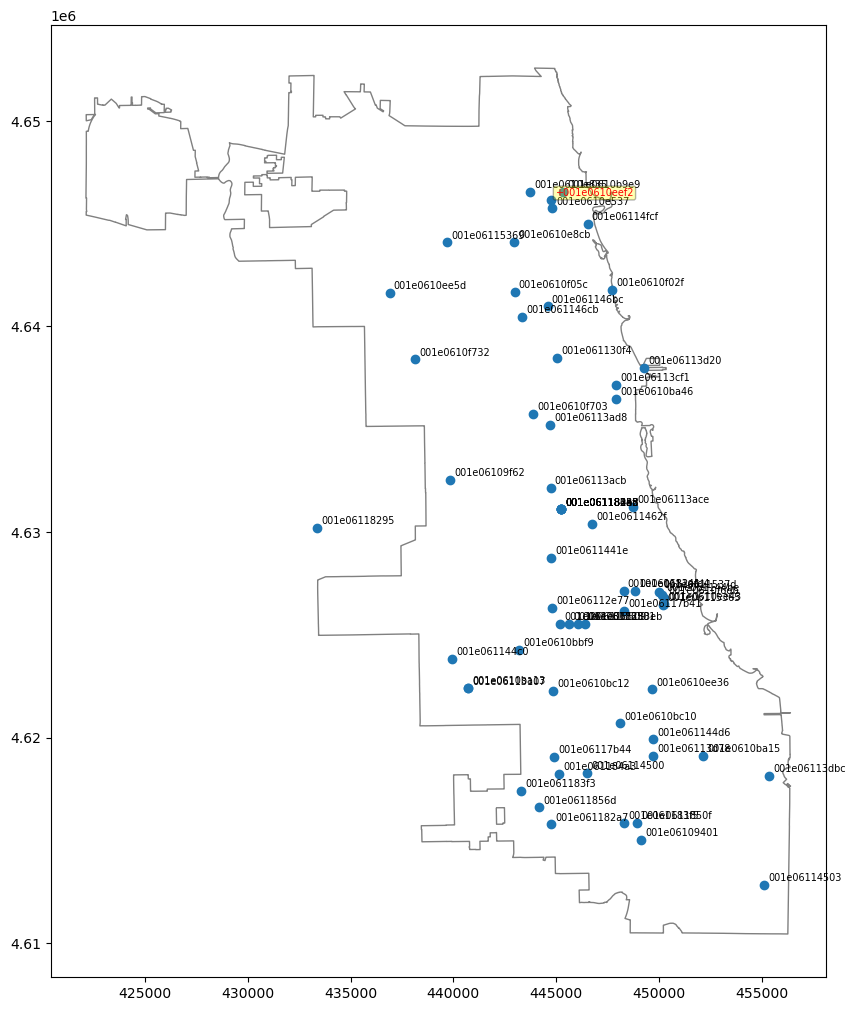

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax=plt.subplots(figsize=(10,15))

def ax_annotate(gdf,annotate_column,highlight=None,ax=ax,**setting):
    setting_dict=dict(fontsize=10,
                      xytext=(3, 3),
                      color="r",
                      bboxstyle='round,pad=0.2',
                      bbox_fc='yellow',
                      bbox_alpha=0.3,            
                     )
    setting_dict.update(setting)  
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[annotate_column]):
        if label in highlight:
            ax.annotate(f"+{label}", 
                        xy=(x, y), 
                        xytext=setting_dict["xytext"], 
                        textcoords="offset points",
                        fontsize=setting_dict["fontsize"],
                        color=setting_dict["color"],
                        bbox=dict(boxstyle=setting_dict["bboxstyle"], fc=setting_dict["bbox_fc"], alpha=setting_dict["bbox_alpha"]))
        else:
            ax.annotate(label, xy=(x, y), xytext=setting_dict["xytext"], textcoords="offset points",fontsize=setting_dict["fontsize"])



Chicago_boundaries_city=postSQL2gpd(table_name="chicago_boundaries_city",**args.db.db_info)
Chicago_boundaries_city.plot(ax=ax,color='white', edgecolor='gray')

df_group_resample_D_gdf.plot(ax=ax)
ax_annotate(df_group_resample_D_gdf,"node_id",highlight=["001e0610eef2"],ax=ax,fontsize=7)

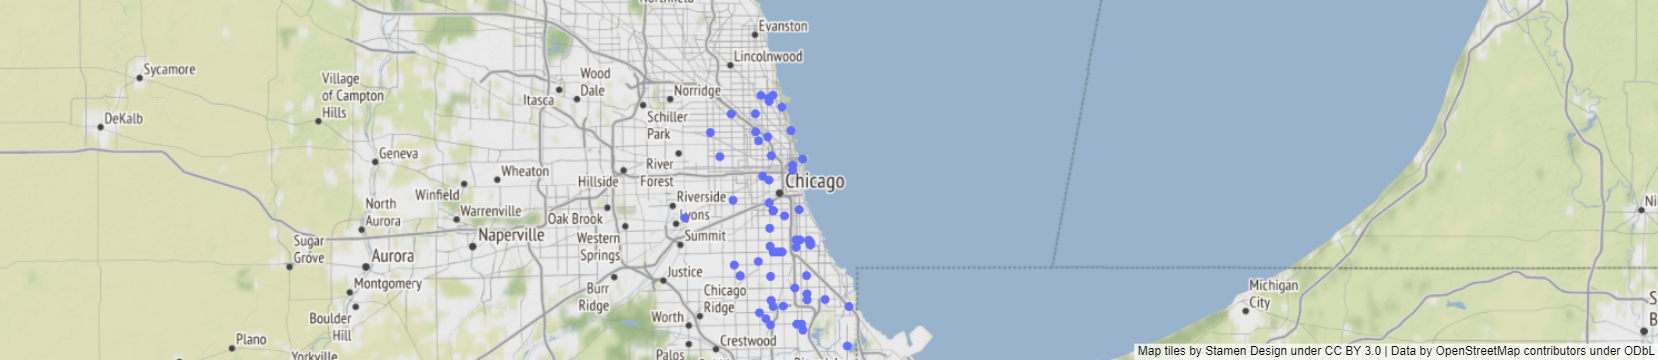

In [27]:
import plotly.graph_objects as go

df_group_resample_D_gdf_wgs84=df_group_resample_D_gdf.to_crs(args.gi.epsg_wgs84)
fig=go.Figure(go.Scattermapbox(mode="markers",
                               lat=df_group_resample_D_gdf_wgs84.geometry.y, 
                               lon=df_group_resample_D_gdf_wgs84.geometry.x,
                               marker={'size': 10},
                               customdata=df_group_resample_D_gdf_wgs84[['Y_mean','node_id']],
                               hovertemplate="<br>".join(["node_id: %{customdata[1]}","D_mean:%{customdata[0]:.3f}",])
                              ),) 
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -87.66372, 'lat': 41.75114},
        'zoom': 10})
fig.show()

---

注释（Notes）：

① 

参考文献（References）:

[1]